In [1]:
! pip install --upgrade pandas
! pip install --upgrade pandas-datareader

In [2]:
! pip install yfinance

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as dr


In [4]:
start_date = '2012-01-01'
end_date = '2022-06-30'
data = dr.DataReader('SBIN.NS','yahoo', start_date, end_date)
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-02,163.600006,161.139999,162.899994,162.764999,14464990.0,145.608521
2012-01-03,171.000000,164.300003,164.399994,170.565002,21341020.0,152.586334
2012-01-04,171.389999,167.520004,171.199997,169.604996,22241630.0,151.727493
2012-01-05,171.854996,168.005005,169.600006,169.244995,21344840.0,151.405472
2012-01-06,170.759995,165.804993,167.500000,167.274994,21137420.0,149.643143


In [5]:
data.shape

(2588, 6)

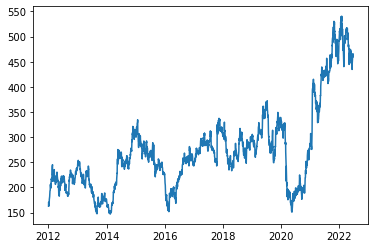

In [6]:
#data= data.reset_index()
plt.plot(data.Close)

In [7]:
data = data[['Close']]
data

,Close
Date,
2012-01-02,162.764999
2012-01-03,170.565002
2012-01-04,169.604996
2012-01-05,169.244995
2012-01-06,167.274994
...,...
2022-06-24,454.250000
2022-06-27,461.200012
2022-06-28,464.250000


In [8]:
# moving average for 100 days 
ma100 = data.Close.rolling(100).mean()


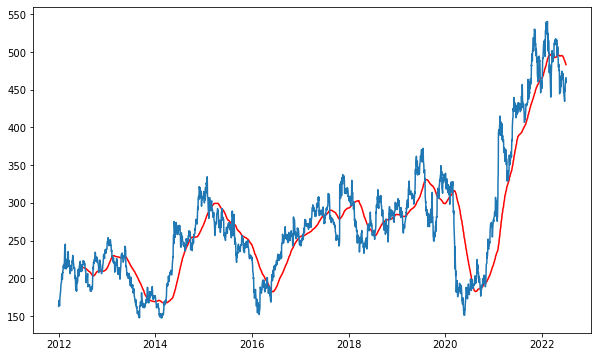

In [9]:
#visualize
plt.figure(figsize =(10,6))
plt.plot(ma100,'r')
plt.plot(data.Close)

In [10]:
data.shape

(2588, 1)

In [11]:
data_train = pd.DataFrame(data.Close[:int(len(data)*0.80)])
data_test = pd.DataFrame(data.Close[int(len(data)*0.80):])

In [12]:
data_train.shape,data_test.shape

((2070, 1), (518, 1))

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range =(0,1))

In [14]:
#values = data.Close.values
#values = values.reshape(-1,1)

In [15]:
scaled_train = scaler.fit_transform(data_train)
scaled_test = scaler.fit_transform(data_test)
#scaled_test

In [16]:
# preparing dataset for lstm 

def dataset_lstm(dataset,steps):
  x_train,y_train =[],[]
  for i in range(len(dataset)-steps-1):
    a = dataset[i:(i+steps),0]
    x_train.append(a)
    y_train.append(dataset[i+steps,0])
  return np.array(x_train),np.array(y_train)

In [17]:
steps = 50
x_train,y_train = dataset_lstm(scaled_train,steps)
x_test,y_test = dataset_lstm(scaled_test,steps)

In [18]:
x_train.shape,y_train.shape

((2019, 50), (2019,))

In [19]:
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout

In [20]:
model = Sequential()
model.add(LSTM(units =150,return_sequences=True,activation = 'relu',input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units =100,activation = 'relu',return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units =150))
model.add(Dense(units =1,activation ='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 150)           91200     
                                                                 
 dropout (Dropout)           (None, 50, 150)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 100)           100400    
                                                                 
 dropout_1 (Dropout)         (None, 50, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 150)               150600    
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 342,351
Trainable params: 342,351
Non-trai

In [21]:
model.compile(loss = 'mean_squared_error',optimizer ='adam')
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs =30,batch_size =64,verbose =1)

Epoch 1/30
32/32 [==============================] - 13s 174ms/step - loss: 0.0374 - val_loss: 0.0047
Epoch 2/30
32/32 [==============================] - 5s 143ms/step - loss: 0.0059 - val_loss: 0.0039
Epoch 3/30
32/32 [==============================] - 5s 142ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 4/30
32/32 [==============================] - 4s 140ms/step - loss: 0.0036 - val_loss: 0.0026
Epoch 5/30
32/32 [==============================] - 5s 143ms/step - loss: 0.0032 - val_loss: 0.0042
Epoch 6/30
32/32 [==============================] - 5s 141ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 7/30
32/32 [==============================] - 5s 145ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 8/30
32/32 [==============================] - 5s 142ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 9/30
32/32 [==============================] - 5s 143ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 10/30
32/32 [==============================] - 5s 141ms/step - loss: 0.0027 - val_loss: 0.001

In [22]:
model.save('time_series_model.h5')

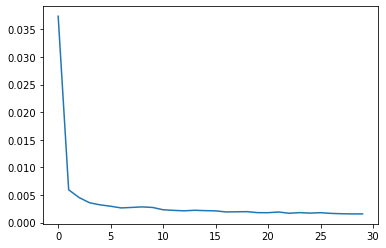

In [23]:
loss = model.history.history['loss']
plt.plot(loss)    

In [24]:
data_test.head()

,Close
Date,
2020-06-05,187.800003
2020-06-08,186.800003
2020-06-09,184.449997
2020-06-10,187.699997
2020-06-11,177.149994


In [25]:
previous_50_data = data_train.tail(50)
final_test_data = previous_50_data.append(data_test,ignore_index= True)

C:\Users\sharm\AppData\Local\Temp\ipykernel_32952\3305041397.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_test_data = previous_50_data.append(data_test,ignore_index= True)


In [26]:
data_test.shape, final_test_data.shape


((518, 1), (568, 1))

In [27]:
final_test_data = scaler.fit_transform(final_test_data)

In [28]:
final_x_test, final_y_test = dataset_lstm(final_test_data,steps)

In [29]:
final_y_test.shape

(517,)

In [30]:
#final_y_test

In [31]:
y_predict = model.predict(final_x_test)

17/17 [==============================] - 4s 27ms/step


In [32]:
#y_predict

In [33]:
scaler.scale_

array([0.00256608])

In [34]:
final_y_test = scaler.inverse_transform(final_y_test.reshape(-1,1))
y_predict = scaler.inverse_transform(y_predict)

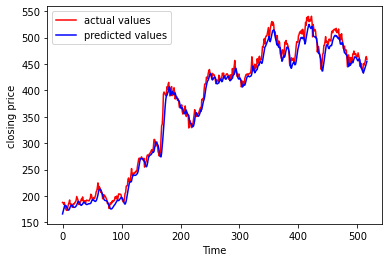

In [35]:
plt.plot(final_y_test, 'r',label ='actual values')
plt.plot(y_predict, 'b',label = 'predicted values')
plt.xlabel("Time")
plt.ylabel('closing price')
plt.legend()
plt.show()

In [36]:
train_predict = model.predict(x_train)
train_predict =scaler.inverse_transform(train_predict)

64/64 [==============================] - 2s 28ms/step


<function matplotlib.pyplot.show(close=None, block=None)>

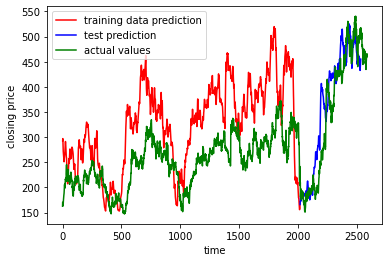

In [63]:
train_predict.shape,y_predict.shape
plt.plot(np.arange(1,len(x_train)+1),train_predict,'r',label = 'training data prediction')
plt.plot(np.arange(len(x_train),2536),y_predict, 'b',label = 'test prediction')
#plt.plot(scaler.inverse_transform(y_train.reshape(-1,1)),'g')
plt.plot(data.Close.values, 'g',label ='actual values')
plt.xlabel('time')
plt.ylabel('closing price')
plt.legend()
plt.show

In [64]:
#x_train.shape,x_test.shape,y_train.shape,y_test.shape,y_predict.shape,train_predict.shape

((2019, 50), (467, 50), (2019,), (467,), (517, 1), (2019, 1))

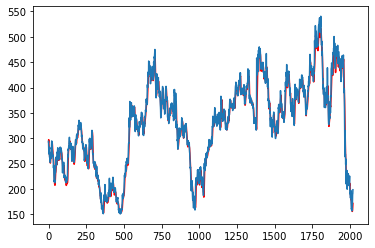

In [65]:
plt.plot(train_predict,'r')
plt.plot(scaler.inverse_transform(y_train.reshape(-1,1)))